# __Car Accident Severity__

### __Introduction__

The present work of reporting, modeling and construction of a Machine Learning solution aims to demonstrate the relationship of environmental and situational variables in the severity of car accidents for the Settle area.

In the first section, an exploratory analysis of the variables to be used will be carried out, emphasizing the distributions and the relationship between the explanatory variables and the category to be predicted.

Second, we will talk about the methodology to be used in the development of the project. A classification model through trees is proposed and studied.

Later, we will jointly study the results of the main evaluation measures, we will review the main postulates of the model and how we can use the solution in a production model.

Finally, we will give a brief review of what was done during the entire Coursera course and its impact on the development of this Capstone deliverable.

### __Data Loading and Transformation__

The modules to be used are the basic ones to implement a classification model. They are found within the Sklearn library, in addition to the now classic numpy and pandas.

In view of the fact that on some occasions it is essential to be able to have a lightweight model that can be executed in any environment, the choice is to use the simplest versions of sklearn models. However, it is recommended to use other types of classifiers or algorithms. For example, those who are extremely famous in Kaggle competitions, such as LightGBM or XGBoost

In [95]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
import pandas as pd 
import matplotlib.pyplot as plt
import altair

Due to space issues, all the preprocessing logic is saved, that is, the working method for identifying the most used variables. However, it can be said that both correlation mapping has been done to identify those much more related. In addition, a categorical modification has been implemented through the pandas get_dummies function. Expanding in this way the dataset and helping the algorithm to have a better approximation.

In [96]:
# Loading Data and validating NANS in it. 
# Si el número de datos NAN es mayor al 50 % entonces no es una columna valida. 
variables = [
    "SEVERITYCODE", "X", "Y", "ADDRTYPE", "HITPARKEDCAR", "COLLISIONTYPE", "PERSONCOUNT", "PEDCOUNT",
    "PEDCYLCOUNT", "VEHCOUNT", "UNDERINFL", "WEATHER", "ROADCOND", "LIGHTCOND", "SPEEDING", "ST_COLCODE"
]
data = pd.read_csv("datasets/Data-Collisions.csv")[variables]

data["SPEEDING"] = data["SPEEDING"].apply(lambda x: 1 if x == "Y" else 0 )
valid_columns = []
for i in data.columns: 
    if data[i].isna().sum()/len(data) >0.4: 
        pass
    else: 
        valid_columns.append(i)
        
data = data[valid_columns]
data.dropna(inplace = True)

#Adding Dummies
# Convert Categorical Variables: 
weather = pd.get_dummies(data.WEATHER)
road_con = pd.get_dummies(data.ROADCOND)
colicion_d  = pd.get_dummies(data.COLLISIONTYPE)
light_d  = pd.get_dummies(data.LIGHTCOND)
add_d  = pd.get_dummies(data.ADDRTYPE)


data= pd.concat([data, weather], axis = 1)
data= pd.concat([data, road_con], axis = 1)
data= pd.concat([data, colicion_d], axis = 1)
data= pd.concat([data, light_d], axis = 1)
data= pd.concat([data, add_d], axis = 1)

data["HITPARKEDCAR"] = data["HITPARKEDCAR"].apply(lambda x: 0 if x== "N" else 1)
data["SEVERITYCODE"] = data["SEVERITYCODE"].apply(lambda x: 0 if x== 1 else 1)

variable = []

for i in data.UNDERINFL: 
    if i == "N": 
        variable.append(0)
    if i == "0": 
        variable.append(0)
    if i == "1": 
        variable.append(1)
    if i == "Y": 
        variable.append(1)
        
data["UNDERINFL"]= variable

data.drop(columns = ["WEATHER", "ROADCOND", "COLLISIONTYPE", "LIGHTCOND", "ADDRTYPE"], inplace =True) 

### __Data Analysis__

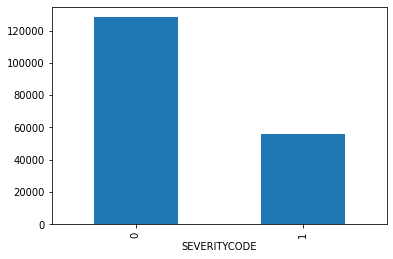

In [105]:
# Severity Code Distribution
data.groupby("SEVERITYCODE")["X"].count().plot(kind = "bar")
plt.show()

It is interesting to review the distribution of the available data, which has allowed us to verify that the classes between which we are trying to make the distinction with the tree classification model offer a problem when training. This is mainly due to the fact that when a split is performed for the trainset and the test set it does so randomly. Causing you to have less information for training about severity(1) instead non severity(0). That is, the problem arises since the number of entries that have a record of 0, no severity is more than double the entries related to some level of severity.

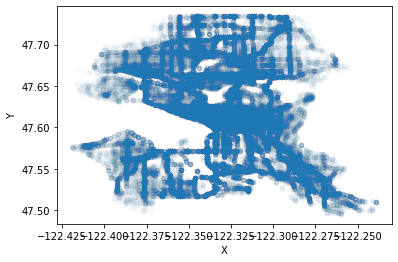

In [116]:
# Car Accident Map
data.plot(x = "X", y = "Y", kind = "scatter", alpha = 0.01)
plt.show()

On the map, we have plotted the coordinates of the accident events found in the Seattle database. As we can see, it is possible to identify a grid scheme that coincides with the most important streets in the Area; In addition, it is possible to verify event crowds in certain areas of the city.

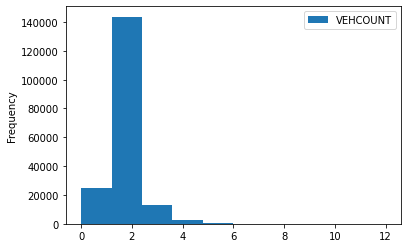

In [140]:
# Vehicle Count
data[["VEHCOUNT"]].plot(kind = "hist")
plt.show()

### __Methodology__

Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Decision trees are among the most popular machine learning algorithms given their intelligibility and simplicity. 

A tree is built by splitting the source set, constituting the root node of the tree, into subsets—which constitute the successor children. The splitting is based on a set of splitting rules based on classification features. This process is repeated on each derived subset in a recursive manner called recursive partitioning. The recursion is completed when the subset at a node has all the same values of the target variable, or when splitting no longer adds value to the predictions. This process of top-down induction of decision trees (TDIDT is an example of a greedy algorithm, and it is by far the most common strategy for learning decision trees from data.

#### Advantages
Amongst other data mining methods, decision trees have various advantages:

Simple to understand and interpret. People are able to understand decision tree models after a brief explanation. Trees can also be displayed graphically in a way that is easy for non-experts to interpret.
Able to handle both numerical and categorical data. Other techniques are usually specialized in analyzing datasets that have only one type of variable. (For example, relation rules can be used only with nominal variables while neural networks can be used only with numerical variables or categoricals converted to 0-1 values.) Early decision trees were only capable of handling categorical variables, but more recent versions, such as C4.5, do not have this limitation.
Requires little data preparation. Other techniques often require data normalization. Since trees can handle qualitative predictors, there is no need to create dummy variables.[21]
Uses a white box or open-box model. If a given situation is observable in a model the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model, the explanation for the results is typically difficult to understand, for example with an artificial neural network.
Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
Non-statistical approach that makes no assumptions of the training data or prediction residuals; e.g., no distributional, independence, or constant variance assumptions
Performs well with large datasets. Large amounts of data can be analyzed using standard computing resources in reasonable time.
Mirrors human decision making more closely than other approaches. This could be useful when modeling human decisions/behavior.
Robust against co-linearity, particularly boosting
In built feature selection. Additional irrelevant feature will be less used so that they can be removed on subsequent runs. The hierarchy of attributes in a decision tree reflects the importance of attributes.[22] It means that the features on top are the most informative.
Decision trees can approximate any Boolean function eq. XOR.

#### Limitations

Trees can be very non-robust. A small change in the training data can result in a large change in the tree and consequently the final predictions
The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts.Consequently, practical decision-tree learning algorithms are based on heuristics such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. To reduce the greedy effect of local optimality, some methods such as the dual information distance (DID) tree were proposed.
Decision-tree learners can create over-complex trees that do not generalize well from the training data. (This is known as overfitting.) Mechanisms such as pruning are necessary to avoid this problem (with the exception of some algorithms such as the Conditional Inference approach, that does not require pruning).
For data including categorical variables with different numbers of levels, information gain in decision trees is biased in favor of attributes with more levels.However, the issue of biased predictor selection is avoided by the Conditional Inference approach, a two-stage approach, or adaptive leave-one-out feature selection.

### Implementation

In [141]:
y = data["SEVERITYCODE"]
X = data.loc[:, data.columns != 'SEVERITYCODE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

### __Results__

Although the model has an acceptable level of accuracy for a prediction (close to 70%), it is possible to have a stable and easily scalable solution, so the possibility of an increase in the amount of information available for training can substantially improve our model's ability to predict class. Furthermore, it is necessary to remember that the classification basically consisted of identifying the level of severity of a crash.

In [142]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6917187075753461


### __Conclusion__

Data science models should have two main focuses: 
   1. Customer; 
   2. Infrastructure.

This means that the most important process in data science is the identification of the business problem we are trying to solve. This implies a continuous and iterative process of interaction with the client, both internal and external, to ensure that the problem has to be solved in the sense that we are giving it. It is also highly recommended to have constant communication with the owners of the MVP in order to guarantee usability.

On the other hand, it is also important to take into account the limitations of the infrastructure where the solution will end up being assembled, that is, it is useless to have the trained model with the best performance if it weighs more than 1gb and it is not possible that it be used at through queries to an API, for example. In this sense, it is extremely important to take infrastructure into account. Personally, I consider that the best option, in the case of scalability and ease of use, is Watson, however, for capacity and power, in addition to availability, AWS takes the crown. Not to mention that it has an extremely useful billing alert system, which could help reduce implementation costs.